# w261 Final Project - Clickthrough Rate Prediction


[Your team number (from the spreadsheet)]   
[Your team names]   
Summer 2019, section [Your section numbers>]   

## Table of Contents

* __Section 1__ - Question Formulation
* __Section 2__ - Algorithm Explanation
* __Section 3__ - EDA & Challenges
* __Section 4__ - Algorithm Implementation
* __Section 5__ - Course Concepts

In [3]:
from pyspark.sql import types
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Set the variable to True if running spark locally, to False if running this notebook using week 08 environment
local = True

In [5]:

if local:
    # run if using local
    app_name = "final_project"
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
    # get the working directory
    PWD = !pwd
    PWD = PWD[0]
    
else:
    # run if using wk08 environment
    sqlContext = SQLContext(sc)
    
sc = spark.sparkContext

In [6]:
sc.getConf().getAll()

[('spark.app.name', 'final_project'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1575396431869'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', 'docker.w261'),
 ('spark.driver.port', '41157')]

# __Section 1__ - Question Formulation

# __Section 2__ - Algorithm Explanation

How do we justify the selection of a particular algorithm for our project?
1. when data is sparse, FM and FFM work better (need to see if the data is sparse)
2. how to justify the choice of FFM over neronets, and trees and other algorithm??

# __Section 3__ - EDA & Challenges

In this section, we seek to understand the important characteristics of the training dataset and how we can use them to inform our implementation of the FFM algorithm. 

## About the data

__(write some general intro about the data and create the parquet file we need to use to perform EDA)__

In [ ]:
# create a parquet file that can be used to perform EDA to increase performance

# if local:
#     train_data = spark.read.csv(f"{PWD}/data/train.txt", sep="\t")
#     train_data.write.format("parquet").save(f"{PWD}/data/train.parquet")
# else:
#     train_data = spark.read.csv("gs://w261-bucket-hou/final-project/data/train.txt", sep="\t")
#     train_data.write.format("parquet").save("gs://w261-bucket-hou/final-project/data/train.parquet")


# In local environment randomly sample 5000 records to form a medium set for code testing

# if local:
#     samples = train_data.takeSample(False, 5000)
#     with open(PWD + f"{PWD}/data/mediumTrain.txt", 'w') as filehandle:
#         for listitem in samples:
#             filehandle.write('%s\n' % listitem)
#     filehandle.close()
#     train_data = spark.read.csv(f"{PWD}/data/mediumTrain.txt", sep="\t")
#     train_data.write.format("parquet").save(f"{PWD}/data/mediumTrain.parquet")

In [7]:
# load the data. By default, we only load the mediumTrain.txt in local environment because the full dataset is too slow to run in local environment

if local:
    # train_parquet = spark.read.parquet(f"{PWD}/data/train.parquet")
    train_parquet = spark.read.parquet(f"{PWD}/data/mediumTrain.parquet")
else: # if using wk08 environment load the file from my bucket
    train_parquet = spark.read.parquet("gs://w261-bucket-hou/final-project/data/train.parquet")

oldColNames = train_parquet.schema.names

In [8]:
#rename files and recast integer types on the first 13 features
train_parquet = train_parquet.withColumn("label", train_parquet["_c0"])
for colNum in range(1,14): 
    colName = "_c" + str(colNum)
    train_parquet = train_parquet.withColumn("int_feature_"+ str(colNum), train_parquet[colName].cast(types.IntegerType()))
for colNum in range(14,40): 
    colName = "_c" + str(colNum)
    train_parquet = train_parquet.withColumn("cate_feature_"+ str(colNum-13), train_parquet[colName])

#drop the old columns
train_parquet = train_parquet.drop(*oldColNames)

In [9]:
#record feature names by feature type
intFieldNames = [colName for colName, dType in train_parquet.dtypes if dType == 'int']
cateFieldNames = [colName for colName, dType in train_parquet.dtypes if dType == 'string' and colName != 'label']

## EDA 1: Overview of the training data

We will take a look at the general properties of the training data in this section, such as the shape of the dataset and the counts of null and distinct values of each column.

In [10]:
recCount = train_parquet.count() #get record count
fieldCount = len(train_parquet.columns)-1 #get the count of features

In [11]:
#Get the counts of distinct values and null values in each columns in the data set

distinctValues = []
nullValues = []
for colName in train_parquet.schema.names:
    distinctValues.append(train_parquet.select(colName).distinct().count())
    nullValues.append(train_parquet.filter((train_parquet[colName] == "") | train_parquet[colName].isNull() | isnan(train_parquet[colName])).count())

In [12]:
print("Training Dataset Overview:\n")
print("Record Count:", recCount)
print("Feature Count:", fieldCount)
print("Total Distinct Categorical Values:", np.sum(distinctValues[14:]))
print("Null Value Percentage:", str(round(float(sum(nullValues))/(recCount*fieldCount)*100,1)) + "%")

print("="*70, "\n")


print("Column Level Information:\n")
print('%-15s| %-15s| %-15s| %-15s' %('Field Name','Distinct Count', 'Null Count', 'Null Percent'))
print('-'*70)
for colName, distinctVal, nullVal in zip(train_parquet.schema.names, distinctValues, nullValues):
    print('%-15s| %-15s| %-15s| %-15s' %(colName, distinctVal, nullVal, str(round(float(nullVal)/recCount*100,1)) + "%" ))

Training Dataset Overview:

Record Count: 5000
Feature Count: 39
Total Distinct Categorical Values: 28063
Null Value Percentage: 14.2%

Column Level Information:

Field Name     | Distinct Count | Null Count     | Null Percent   
----------------------------------------------------------------------
label          | 2              | 0              | 0.0%           
int_feature_1  | 63             | 2212           | 44.2%          
int_feature_2  | 570            | 0              | 0.0%           
int_feature_3  | 208            | 1072           | 21.4%          
int_feature_4  | 63             | 1034           | 20.7%          
int_feature_5  | 3233           | 130            | 2.6%           
int_feature_6  | 567            | 1099           | 22.0%          
int_feature_7  | 207            | 215            | 4.3%           
int_feature_8  | 52             | 3              | 0.1%           
int_feature_9  | 582            | 215            | 4.3%           
int_feature_10 | 6           

__EDA 1 Findings:__

There are a few things we see in our dataset that helps inform our implementation:

> We have a total of $45,840,617$ records in the `train.txt`. We would still have $45,840,617 \cdot 80\% = 36,672,493$ records we can use to train our model even if we do a 80%, 20% split and save the 20% for validation. With this many records in our dataset and the difficulty in parallelize stochastic gradient descent, we might explore using mini-batch gradient descent to speed up training.

> $14.2\%$ of the data has null values, and some categorical features (see `cate_feature_3`, `cate_feature_16` and etc...) have a large number of distinct values. With these two properties, if we simply one-hot encode the categorial variable, we will have a vary sparse dataset. To efficiently store the data in memory, we need to consider using a more dense representation of the data similar to stripes or pairs introduced in class.

> We notice that categorical features (see `cate_feature_3`, `cate_feature_16` and etc...) with a large number of distinct values might imply very low counts of records per values which will make our model prone to overfitting and reduce the generalizability. For example, if we train many parameters on only a few records, would mean we are training our model based on some specific information only contained in this particular training set. Therefore, in the next EDA section, we will explore this topic further and suggest ways to deal with this issue if it exists.

## EDA 2: Categorical Features

In this section of EDA, we will take a look at the categorical variables in the dataset with the main goal of exploring how many instances we have for each distinct value which is equivalent to a feature after one-hot encoding.

In [13]:
def get_distinct_summary(df, col, thresholds):
    """
    Helper function which helps calculate the numbers of distinct values left after
    exluding those whose count of instances is lower than given thresholds
    
    Args:
        df         - a spark dataframe of the entire dataset
        col        - the column name of the column used in the calculation
        thresholds - a list of numbers used as the thresholds
    Returns:
        summary_values - a list: 
                         1. first element as the column name
                         2. second element as the distinct value count
                         3. the following elements as the counts of distinct values left 
                            after exluding the ones having counts lower than the threshold.
    """
    
    summary_values = [col]
    summary_values.append(df.select(col).distinct().count())
    
    count_df = df.groupBy(col).count()
    filtered_counts = [count_df.filter(f"count >= {threshold}").count() + 1 for threshold in thresholds]
    summary_values.extend(filtered_counts)
    
    return [str(val) for val in summary_values]

In [14]:
# get the distinct value counts for all categorical variables for the thresholds below

thresholds = [5, 10, 25, 50, 100, 500, 1000]
distinct_summary = [get_distinct_summary(train_parquet, c, thresholds) for c in cateFieldNames]

In [15]:
# calculate the number and the percentage of feature preserved for a given threshold

distinct_counts = np.asarray(distinct_summary)[:,1:].astype(int)
feat_num = np.sum(distinct_counts, axis = 0)
feat_percent_preserv = np.sum(distinct_counts, axis = 0)/np.sum(distinct_counts, axis = 0)[0]

Text(0.5,1,'Feature Counts by Threshold')

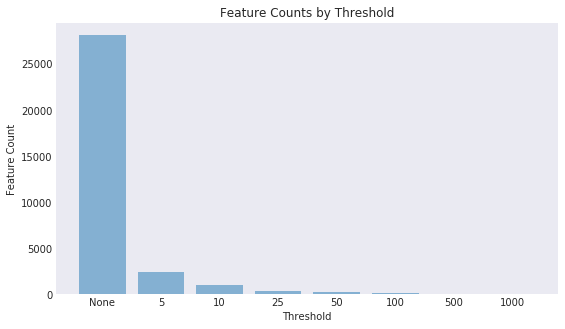

In [16]:
# plot feature counts by threshold

plt.figure(figsize=(9, 5))


Ts = ['None'] + [f"{threshold}" for threshold in thresholds]
y_pos = np.arange(len(Ts))

plt.bar(y_pos, feat_num, align='center', alpha=0.5)
plt.xticks(y_pos, Ts)
plt.ylabel('Feature Count')
plt.xlabel('Threshold')
plt.title('Feature Counts by Threshold')

In [17]:
# show the distinct value count for all categorical variables for all thresholds and the summary at the bottom

eda2_summary = distinct_summary + [["***Total***"] + [str(num) for num in feat_num]]
eda2_summary = eda2_summary + [["***% Preserved***"] + [str(round(percent*100,1))+"%" for percent in feat_percent_preserv]]


distinctCounts = spark.createDataFrame(eda2_summary, ['Feature', 'Distinct'] + [f"count >= {threshold}" for threshold in thresholds] )
distinctCounts.show(40)

+-----------------+--------+----------+-----------+-----------+-----------+------------+------------+-------------+
|          Feature|Distinct|count >= 5|count >= 10|count >= 25|count >= 50|count >= 100|count >= 500|count >= 1000|
+-----------------+--------+----------+-----------+-----------+-----------+------------+------------+-------------+
|   cate_feature_1|     115|        35|         22|         13|          9|           7|           3|            2|
|   cate_feature_2|     332|       144|         95|         41|         20|          12|           2|            1|
|   cate_feature_3|    3292|        93|         41|         14|          5|           3|           1|            1|
|   cate_feature_4|    2421|       122|         55|         17|         10|           6|           1|            1|
|   cate_feature_5|      48|        19|         13|         10|          7|           6|           3|            2|
|   cate_feature_6|       7|         8|          8|          8|         

__EDA 2 Findings:__

> In this section, we found that most of the values of the categorical features have very few counts. Even a threshold of five occurance would cause a drastic drop in feature number (refer to the bar graph above). Looking at the row, `***% Preserved***` in the table above, we only have 6.2% of the values left if we set the threshold for minimum occurance to be 5 and 3.2% left when the threshold is set to 10. This piece of information helps inform the feature engineering. We will need to establish a threshold to exlude these values having very low occurances so we don't train our model with local trend that doesn't exist in the popultion.

> Looking at the counts of features left after a given threshold is applied (row, `***Total***` in the table above), we can see that when the threshold is set to ten, we would still have around 1 million one-hot-encoded features, and we can guarantee that all the parameters in our models are trained as least on ten examples. Therefore, we will set the threshold at ten to filter our categorical values. 

> __ARE WE GOING TO ASSIGN A SPECIAL VALUE TO FEATURE BELOW THE THRESHOLD?__


## EDA 3: Integer Features

In this section, we perform an EDA on the integer features (i.e., the first 13 features). The goal is to identify possible feature engineering that will improve our algorithm's performance.

In [50]:
train_parquet.select(intFieldNames[:7]).describe().show()
train_parquet.select(intFieldNames[6:]).describe().show()

+-------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|summary|    int_feature_1|     int_feature_2|    int_feature_3|    int_feature_4|     int_feature_5|     int_feature_6|     int_feature_7|
+-------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|  count|             2788|              5000|             3928|             3966|              4870|              3901|              4785|
|   mean|3.826757532281205|          110.9356| 43.9806517311609|7.389813414019163|17061.030184804928|118.69700076903358| 16.61671891327064|
| stddev| 9.53160896120588|393.61348473815525|870.2330455018677|8.877438545143875| 58911.75067484051| 422.3105054811211|62.123301344325135|
|    min|                0|                -2|                0|                0|                 0|                 0|                 0|
|    max|           

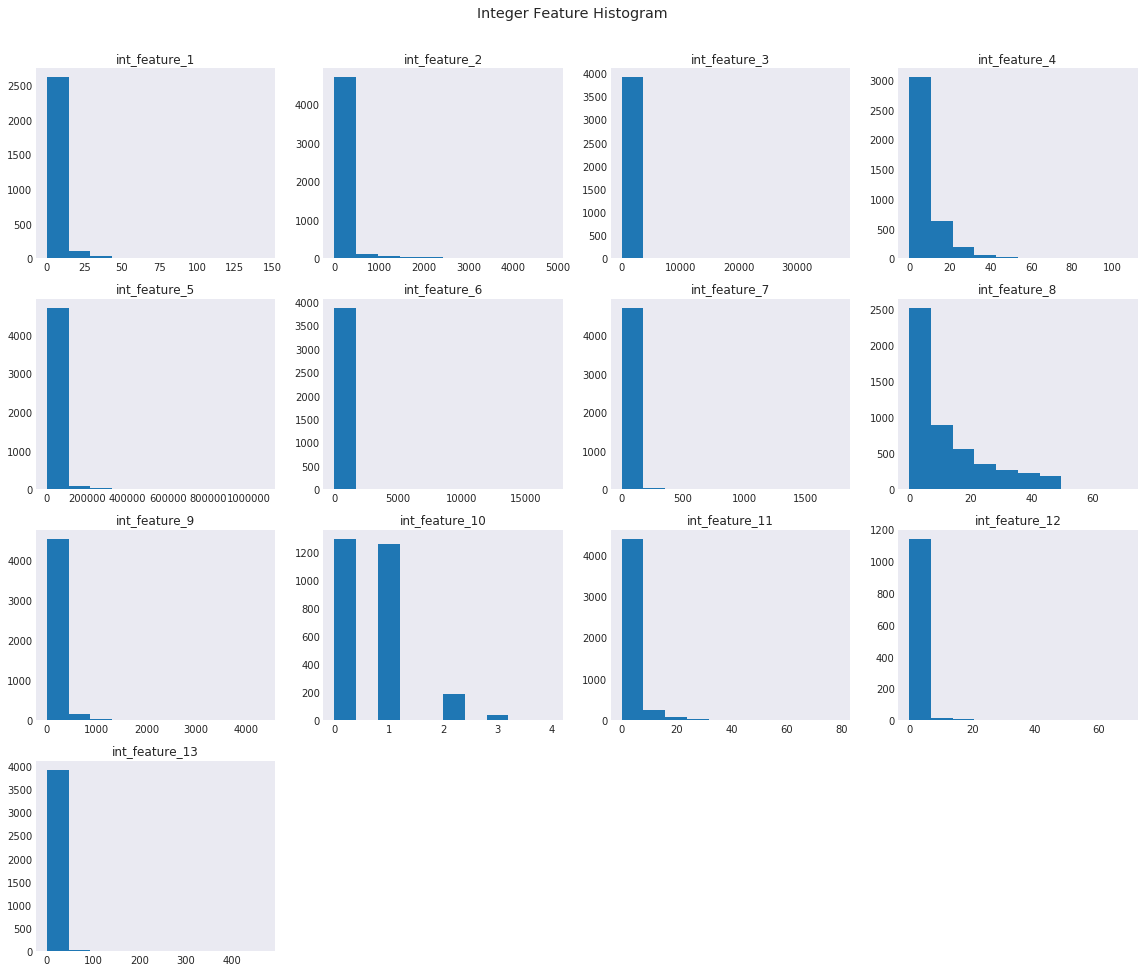

In [69]:
fig = plt.figure(figsize=(16, 16))
for i in range(len(intFieldNames)):
    colName = intFieldNames[i]
    ax = plt.subplot(5, 4, i+1)
    ax.hist(train_parquet.select(colName).rdd.map(lambda r: r[0]).filter(lambda x: x!=None).collect())
    ax.set_title(colName)

st = fig.suptitle("Integer Feature Histogram", fontsize="x-large")
fig.tight_layout()
st.set_y(1.03)

__EDA 3 Findings:__

From both the histograms and statistics summary, we can see that most of the integer features besides `int_feature_10` are very right-skewed with outliers. When fitting to the integers without any feature engineering, we might give the outliers more than appropriate weight in affecting our model's decision-making. Therefore, it is worth it to try transforming the integers by taking the natural log of its value. We will compare the performance of the model with and without the log transformation.

===================================================================================================================================

# __Section 4__ - Algorithm Implementation

# __Section 5__ - Course Concepts